In [62]:
from numpy import array, zeros, allclose, arange, log2, pad, ceil, set_printoptions, append, c_, r_
from numpy.random import random, randint
from time import time
from matplotlib.pyplot import title, plot, legend, show, xlabel, ylabel, figure, loglog
from jupyterthemes import jtplot
jtplot.style(theme = 'monokai')

In [63]:
def naive(A, B):
    m = A.shape[1]
    l = B.shape[1]
    n = A.shape[0] 

    assert B.shape[0] == m, 'The matrices `A` and `B` are incompatible.'

    C = zeros((n, l))
    
    for j in range(l):
        for i in range(n):
            for k in range(m):
                C[i][j] += A[i][k] * B[k][j]

    return C

In [64]:
def recursion(A, B):
    n = A.shape[0]
    
    assert B.shape[0] == A.shape[1] == A.shape[1] == n, 'The matrices `A` and `B` are not square.'
    
    if n < 16:
        return naive(A, B)
    if n % 2 != 0:
        A = r_[c_[A, zeros((n, 1))], zeros((1, n + 1))]  
        B = r_[c_[B, zeros((n, 1))], zeros((1, n + 1))]  
        return recursion(A, B)[0:n, 0:n]

    C = zeros((n, n))
    m = n // 2
    
    for i in m * arange(2):
        for j in m * arange(2):
            C[i:i + m, j:j + m] = recursion(A[i:i + m, 0:m], B[0:m, j:j + m]) + \
                                  recursion(A[i:i + m, m:n], B[m:n, j:j + m]) 

    return C

In [65]:
def divide(A):
    n = A.shape[0] 
    m = n // 2
    return A[0:m, 0:m], A[0:m, m:n], A[m:n, 0:m], A[m:n, m:n]

In [66]:
def strassen(A, B):
    n = A.shape[0]
    
    assert A.shape[1] == n, 'The matrix `A` is not not square.'
    assert B.shape[0] == B.shape[1], 'The matrix `B` is not not square.'
    assert B.shape[0] == n, 'The matrices `A` and `B` are not compatible.'
    
    if n < 16:
        return naive(A, B)
    if n % 2 != 0:
        A = r_[c_[A, zeros((n, 1))], zeros((1, n + 1))]  
        B = r_[c_[B, zeros((n, 1))], zeros((1, n + 1))]  
        C = strassen(A, B)
        return C[0:n, 0:n]

    m = n // 2
    C = zeros((n, n))

    A11, A12, A21, A22 = divide(A)
    B11, B12, B21, B22 = divide(B)

    P1 = strassen(A11, B12 - B22)
    P2 = strassen(A11 + A12, B22)
    P3 = strassen(A21 + A22, B11)
    P4 = strassen(A22, B21 - B11)
    P5 = strassen(A11 + A22, B11 + B22)
    P6 = strassen(A12 - A22, B21 + B22)
    P7 = strassen(A11 - A21, B11 + B12)
    
    C[0:m, 0:m] = P5 + P4 - P2 + P6
    C[0:m, m:n] = P1 + P2
    C[m:n, 0:m] = P3 + P4
    C[m:n, m:n] = P5 + P1 - P3 - P7

    return C

In [67]:
def complexity(function, nmax = 8, dims = array([0, 0, 0])):
    t = [] 
    s = []

    for n in 2 ** arange(nmax):
        k, m, p = n * dims
        
        A = random((k + n, m + n))
        B = random((m + n, p + n))
    
        start = time()
        function(A, B)
        end = time()
    
        s += [n]
        t += [end - start]
    
    return array(s), array(t)

In [68]:
n = 1 + randint(100, size = 1)[0] # Generating random sizes for the matrices
A = random((n, n))
B = random((n, n))
print('Is the na\u00efve algorithm implemented correct?', allclose(naive(A, B), A @ B))
print('Is the recursive algorithm implemented correct?', allclose(recursion(A, B), A @ B))
print('Is the strassen`s algorithm implemented correct?', allclose(strassen(A, B), A @ B))

Is the naïve algorithm implemented correct? True
Is the recursive algorithm implemented correct? True
Is the strassen`s algorithm implemented correct? True


In [69]:
print('Time required by the na\u00efve algorithm:')
%timeit naive(A, B)

print('\nTime required by the recursive algorithm:')
%timeit recursion(A, B)

print('\nTime required by the strassen`s algorithm:')
%timeit strassen(A, B)

Time required by the naïve algorithm:
634 ms ± 31.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time required by the recursive algorithm:
807 ms ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time required by the strassen`s algorithm:
538 ms ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
size = 8
s, t_naive = complexity(naive, nmax = size)
_, t_recursive = complexity(recursion, nmax = size)
_, t_strassen = complexity(strassen, nmax = size)

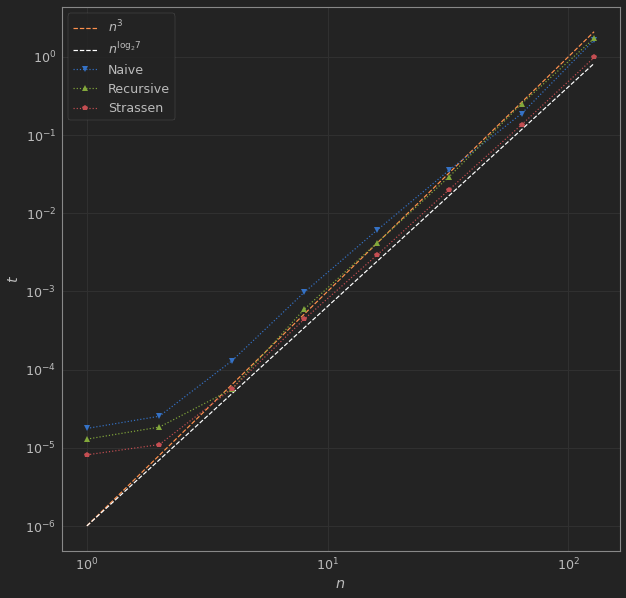

In [71]:
figure(figsize = [10, 10])
x = array(arange(1, 2 ** (size - 1), 0.1)) 
loglog(x, x ** 3 * 1e-6, 'y--', label = '$n^3$')
loglog(x, x ** log2(7) * 1e-6, 'w--', label = '$n^{\log_27}$')
loglog(s, t_naive, 'b:v',  label = 'Naive')
loglog(s, t_recursive, 'g:^', label = 'Recursive') 
loglog(s, t_strassen, 'r:p', label = 'Strassen') 
xlabel('$n$')
ylabel('$t$')
legend()
show()

In [72]:
def generalized_divide(A, l):
    n = A.shape[0]
    m = A.shape[1]
    return A[0:l, 0:l], A[0:l, l:m], A[l:n, 0:l], A[l:n, l:m]

In [80]:
def generalized_strassen(A, B):
    n = A.shape[0]
    m = A.shape[1]
    p = B.shape[1]
    
    assert B.shape[0] == m, 'The matrices `A` and `B` are not compatible.'
    
    if n == m == p:
        return strassen(A, B)
    
    l = min(n, m, p) 
    
    if l < 16:
        return naive(A, B)
    
    A11, A12, A21, A22 = generalized_divide(A, l)
    B11, B12, B21, B22 = generalized_divide(B, l)

    C = zeros((n, p))
    C[0:l, 0:l] += generalized_strassen(A11, B11) 
    
    if m > l:
        C[0:l, 0:l] += generalized_strassen(A12, B21)
        C[0:l, l:p] += generalized_strassen(A12, B22)
        C[l:n, 0:l] += generalized_strassen(A22, B21)
    
    if n > l:
        C[l:n, 0:l] += generalized_strassen(A21, B11)
        
    if p > l:
        C[0:l, l:p] += generalized_strassen(A11, B12)
        
    if n > l and p > l:
        C[l:n, l:p] += generalized_strassen(A21, B12)

    return C

In [81]:
n, m, p = 1 + randint(10, size = 3) # Generating random sizes for the matrices
A = random((n, m))
B = random((m, p))
print('Is the na\u00efve algorithm implemented correct?', allclose(naive(A, B), A @ B))
print('Is the generalized Strassen`s algorithm implemented correct?', allclose(generalized_strassen(A, B), A @ B))

Is the naïve algorithm implemented correct? True
Is the generalized Strassen`s algorithm implemented correct? True


In [82]:
print('Time required by the na\u00efve algorithm:')
%timeit naive(A, B)

print('\nTime required by the recursive algorithm:')
%timeit generalized_strassen(A, B)

Time required by the naïve algorithm:
55.1 µs ± 1.56 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

Time required by the recursive algorithm:
58.3 µs ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
size = 8
dims = randint(5, size = 3)
s, t_naive = complexity(naive, dims = dims, nmax = size)
_, t_general = complexity(generalized_strassen, dims = dims, nmax = size)

In [ ]:
figure(figsize = [10, 10])
x = array(arange(16, 2 ** (size - 1), 0.1)) 
loglog(x, x ** 3 * t_naive[-1] / x[-1] ** 3, 'y--', label = '$n^3$') 
loglog(x, x ** log2(7) * t_general[-1] / x[-1] ** log2(7), 'w--', label = '$n^{\log_27}$')
loglog(s, t_naive, 'b:v',  label = 'Naive')
loglog(s, t_general, 'g:^', label = 'Generalized Strassen') 
xlabel('$n$')
ylabel('$t$')
legend()
show()